# Overall comparison of the models' performance (Diatom Production Rate)

## Importing

In [73]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xskillscore as xs
from sklearn.metrics import root_mean_squared_error as rmse


## Function for 5% mean

In [74]:
def low_mean(a):
    
    return a[0:4].mean(dim="time_counter")


## Daily calculations

In [75]:
def daily(r_days,rms_days,slope_days):

    r = np.zeros(4)
    rms = np.zeros(4)
    slope = np.zeros(4)

    for j in range(0,4):

        r[j] = np.round(r_days[j].values,3)
        rms[j] = rms_days[j].values
        slope[j] =  np.round(slope_days[j].values,3)
    
    return(r,rms,slope)


## Printing (Function)

In [76]:
def printing(metric,years,data,categories,criteria):

     temp = pd.DataFrame(data,columns=years,index=categories)
     print(metric+ ' ' +criteria)
     display(temp)
     print ('\n')


## Plotting (Function)

In [77]:
def plotting (j,metric,categories,years,quantity,name):

    fig,ax = plt.subplots()

    for i in range (0,len(categories)):
        ax.plot(years,quantity[i,:,j],marker= '*', label=categories[i])
    plt.xlabel('Years')
    plt.suptitle(metric+ ' ' +name+ ' (15 Feb - 30 Apr)')
    plt.legend()
    fig.show()


## Calculations

In [78]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

def calculations(species,category):

    r = np.zeros((len(category),4,3)) # First axis is the model categories, second the years, third the calculated metrics
    rms = np.zeros((len(category),4,3))
    slope = np.zeros((len(category),4,3))

    for i in range (0, len(category)):

        ds = xr.open_dataset(species+category[i]+'/targets_predictions.nc')
        targets_all = ds.Targets
        predictions_all = ds.Predictions

        # Annual
        targets_annual = np.ravel(targets_all.groupby('time_counter.year'))
        predictions_annual = np.ravel(predictions_all.groupby('time_counter.year'))

        years = []
        for j in range(1,8,2):

            years.append(targets_annual[j-1])

            idx = np.isfinite(np.ravel(targets_annual[j]))

            r[i,len(years)-1,0] = np.round(np.corrcoef(np.ravel(targets_annual[j])[idx],np.ravel(predictions_annual[j])[idx])[0][1],3)
            rms[i,len(years)-1,0] = rmse(np.ravel(targets_annual[j])[idx],np.ravel(predictions_annual[j])[idx])
            m,_ = np.polyfit(np.ravel(targets_annual[j])[idx], np.ravel(predictions_annual[j])[idx], deg=1)
            slope[i,len(years)-1,0] = np.round(m,3)

        # Daily means
        r_days = xr.corr(targets_all,predictions_all, dim=['x','y']).groupby('time_counter.year').mean('time_counter')
        rms_days = xs.rmse(targets_all,predictions_all, dim=['x','y'], skipna=True).groupby('time_counter.year').mean('time_counter')
        slope_days = xs.linslope(targets_all,predictions_all, dim=['x','y'], skipna=True).groupby('time_counter.year').mean('time_counter')

        r[i,:,1],rms[i,:,1],slope[i,:,1] = daily(r_days,rms_days,slope_days)
    
        # 5% low
        r_days = xr.corr(targets_all,predictions_all, dim=['x','y']).sortby(xr.corr(targets_all,predictions_all, dim=['x','y'])).groupby('time_counter.year').map(low_mean)
        rms_days = xs.rmse(targets_all,predictions_all, dim=['x','y'], skipna=True).sortby(xs.rmse(targets_all,predictions_all, dim=['x','y'], skipna=True),ascending=False).groupby('time_counter.year').map(low_mean)
        slope_days = xs.linslope(targets_all,predictions_all, dim=['x','y'], skipna=True).sortby(xs.linslope(targets_all,predictions_all, dim=['x','y'], skipna=True)).groupby('time_counter.year').map(low_mean)

        r[i,:,2],rms[i,:,2],slope[i,:,2] = daily(r_days,rms_days,slope_days)

    return(years,r,rms,slope)


## Main Body

In [79]:
# Paths
diat = '/data/ibougoudis/MOAD/files/results/Diatom/'
diat_pr = '/data/ibougoudis/MOAD/files/results/Diatom_Production_Rate/'
flag = '/data/ibougoudis/MOAD/files/results/Flagellate/'
flag_pr = '/data/ibougoudis/MOAD/files/results/Flagellate_Production_Rate/'

categories = ['hist_xy2_ext', 'hist_xy4_ext']

metrics = ['Annual', 'Daily mean', '5% low mean']

years,r,rms,slope = calculations(diat_pr,categories)


## Plotting

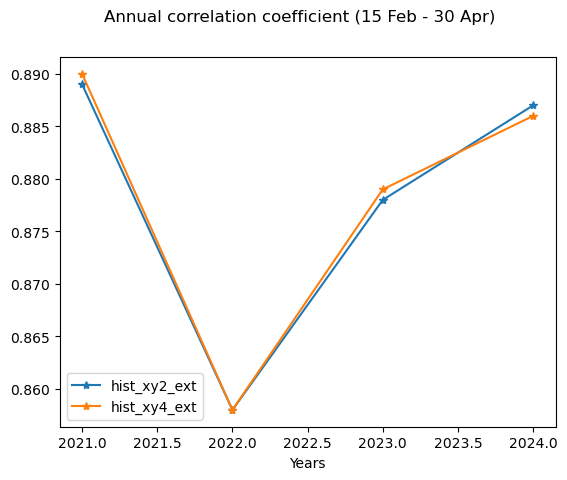

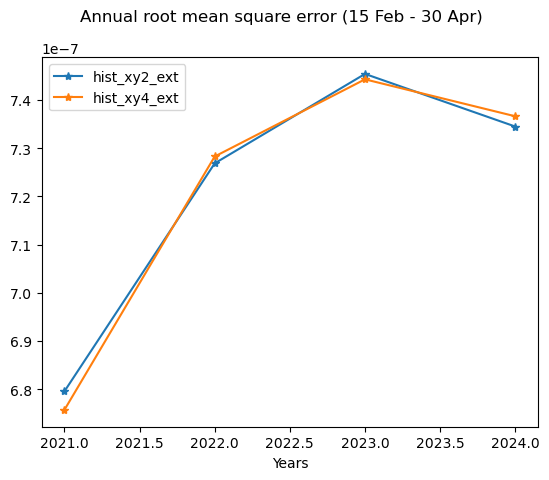

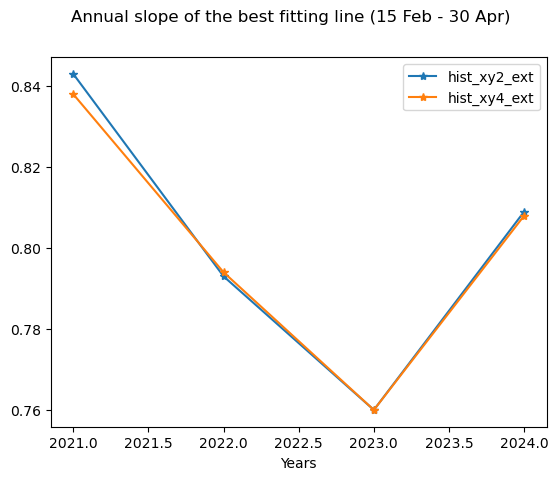

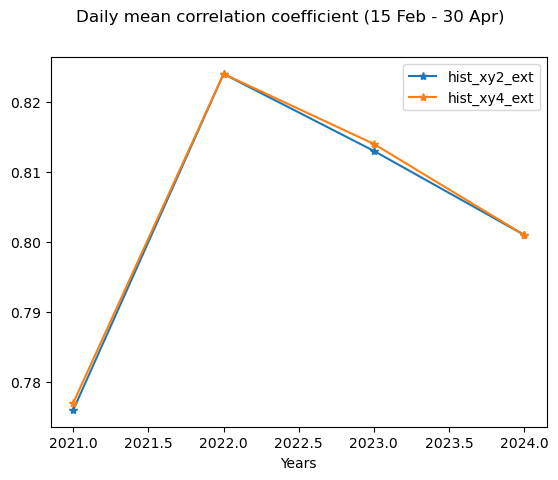

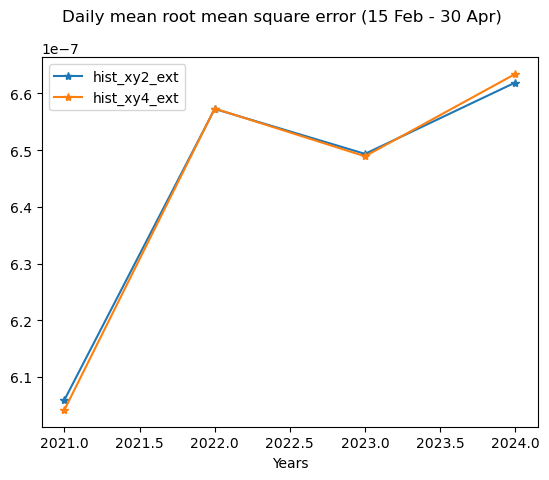

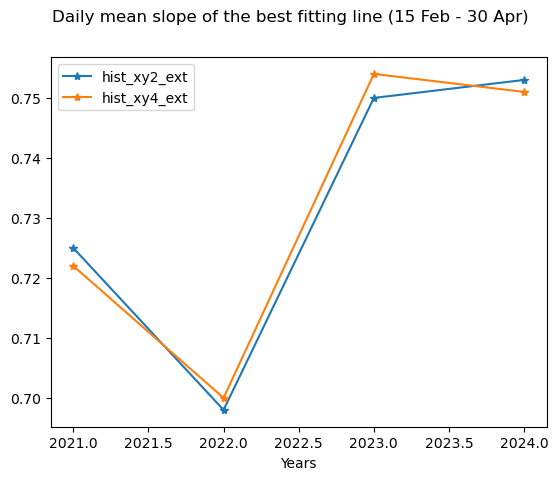

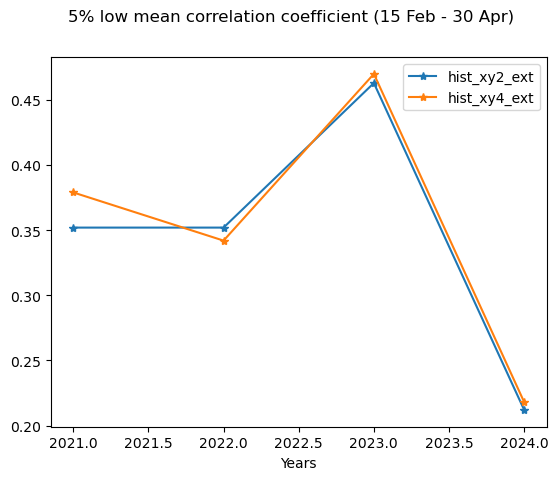

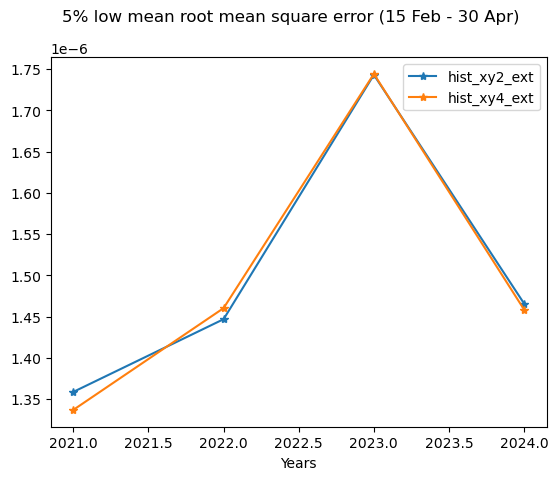

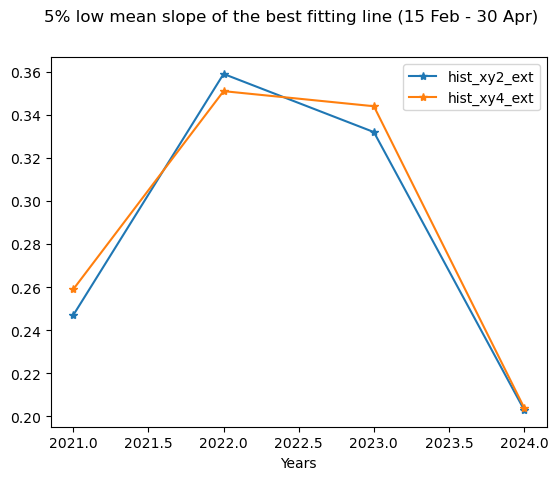

In [80]:
for i in range (0, len(metrics)):

    plotting(i,metrics[i],categories,years,r,'correlation coefficient')
    plotting(i,metrics[i],categories,years,rms,'root mean square error')
    plotting(i,metrics[i],categories,years,slope,'slope of the best fitting line')


## Training

### Correlation coefficient

| Category | Training |
| :-: | :-: |
| hist | .9 | 
| hist + xy | .9 |
| hist + nitr | .9 |
| hist + xy + nitr | .9 |
| hist + fun_cl | .9 |
| hist + fun_cl + nitr | .9 |
| func_reg | .9 |

### Root mean square error

| Category | Training |
| :-: | :-: |
| hist | .9 | 
| hist + xy | .9 |
| hist + nitr | .9 |
| hist + xy + nitr | .9 |
| hist + fun_cl | .9 |
| hist + fun_cl + nitr | .9 |
| func_reg | .9 |

### Slope of the best fitting line

| Category | Training |
| :-: | :-: |
| hist | .9 | 
| hist + xy | .9 |
| hist + nitr | .9 |
| hist + xy + nitr | .9 |
| hist + fun_cl | .9 |
| hist + fun_cl + nitr | .9 |
| func_reg | .9 |

## Printing

In [81]:
for i in range (0,len(metrics)):

    printing(metrics[i],years,r[:,:,i],categories,'Correlation coefficient')
    printing(metrics[i],years,rms[:,:,i],categories, 'Root mean square error')
    printing(metrics[i],years,slope[:,:,i],categories, 'Slope of the best fitting line')
    

Annual Correlation coefficient


,2021,2022,2023,2024
hist_xy2_ext,0.889,0.858,0.878,0.887
hist_xy4_ext,0.890,0.858,0.879,0.886




Annual Root mean square error


,2021,2022,2023,2024
hist_xy2_ext,6.795342e-07,7.268536e-07,7.454083e-07,7.344884e-07
hist_xy4_ext,6.756881e-07,7.282738e-07,7.442867e-07,7.366157e-07




Annual Slope of the best fitting line


,2021,2022,2023,2024
hist_xy2_ext,0.843,0.793,0.76,0.809
hist_xy4_ext,0.838,0.794,0.76,0.808




Daily mean Correlation coefficient


,2021,2022,2023,2024
hist_xy2_ext,0.776,0.824,0.813,0.801
hist_xy4_ext,0.777,0.824,0.814,0.801




Daily mean Root mean square error


,2021,2022,2023,2024
hist_xy2_ext,6.059527e-07,6.572700e-07,6.493423e-07,6.619212e-07
hist_xy4_ext,6.042046e-07,6.573352e-07,6.489169e-07,6.634377e-07




Daily mean Slope of the best fitting line


,2021,2022,2023,2024
hist_xy2_ext,0.725,0.698,0.750,0.753
hist_xy4_ext,0.722,0.700,0.754,0.751




5% low mean Correlation coefficient


,2021,2022,2023,2024
hist_xy2_ext,0.352,0.352,0.463,0.212
hist_xy4_ext,0.379,0.342,0.470,0.218




5% low mean Root mean square error


,2021,2022,2023,2024
hist_xy2_ext,0.000001,0.000001,0.000002,0.000001
hist_xy4_ext,0.000001,0.000001,0.000002,0.000001




5% low mean Slope of the best fitting line


,2021,2022,2023,2024
hist_xy2_ext,0.247,0.359,0.332,0.203
hist_xy4_ext,0.259,0.351,0.344,0.204
